In [1]:
%load_ext autoreload
%autoreload 2

import glob
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, color
from colorize import network, util

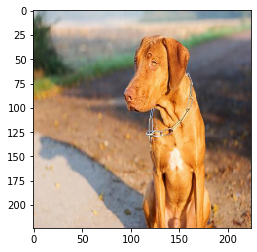

/home/oskar/Programs/miniconda3/envs/ann/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


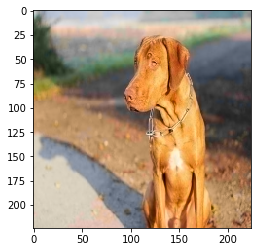

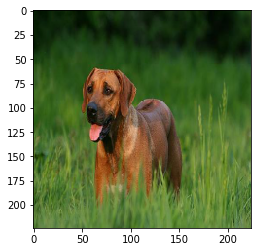

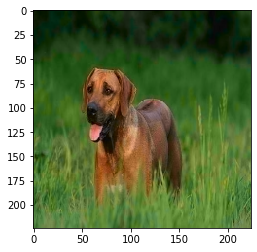

In [2]:
images = glob.glob("data/**/*.jpg")
X, Z = [], []
for path in images:
    L, ab = util.imread(path)
    util.imshow(L, ab)
    X.append(L)
    Y = transform.resize(ab, (56, 56))
    Z.append(util.soft_encode(Y))
    Y_decoded = util.decode(Z[-1])
    Y_decoded = transform.resize(Y_decoded, (224, 224))
    util.imshow(L, Y_decoded)
    
    if len(X) >= 2:
        break

In [3]:
# Create tensors for training
X_tensor = torch.tensor(np.concatenate([util.reshape(x, 4)[0] for x in X], axis=0), dtype=torch.float32)
X_tensor = (X_tensor - 50) / 50
Z_tensor = torch.tensor(np.concatenate([util.reshape(z, 4)[0] for z in Z], axis=0), dtype=torch.float32)
print('X:', X_tensor.shape)
print('Z:', Z_tensor.shape)

X: torch.Size([2, 1, 224, 224])
Z: torch.Size([2, 313, 56, 56])


In [10]:
net = network.Net()
optimizer = torch.optim.Adam(net.parameters())

epochs = 50
for epoch in range(1, epochs + 1):
    optimizer.zero_grad()

    Z_hat = net(X_tensor)
    loss = util.multinomial_cross_entropy_loss(Z_hat, Z_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch}/{epochs}, Loss: {loss.item()}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 112, 112]          36,928
       BatchNorm2d-3         [-1, 64, 112, 112]             128
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5          [-1, 128, 56, 56]         147,584
       BatchNorm2d-6          [-1, 128, 56, 56]             256
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
            Conv2d-9          [-1, 256, 28, 28]         590,080
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
           Conv2d-12          [-1, 512, 28, 28]       2,359,808
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
      BatchNorm2d-14          [-1, 512,

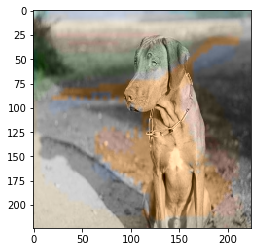

In [13]:
# Show image
index = 0
Z_hat = util.reshape(net(X_tensor)[index:index+1].data.numpy(), 3)[0]
Y_decoded = transform.resize(util.decode(Z_hat), (224, 224))
util.imshow(X[index], Y_decoded)